# PyDeepGP tutorial

In [9]:
import numpy as np
import GPy
from pylab import *
%matplotlib inline
import os
from sys import path
np.random.seed(42)

In [10]:
# Add parent directory to path if deepgp is not there already
pwd = os.getcwd()
base_path = pwd[0:pwd.rfind(os.sep)]
path.insert(0,base_path)

In [11]:
import deepgp

In [12]:
# Utility to load sample data. It can be installed with pip. Otherwise just load some other data.
import pods

## Unsupervised learning (oil data)

In [6]:
# Load data
data = pods.datasets.oil_100()
Y = data['X']
labels =  data['Y'].argmax(axis=1)

# Number of latent dimensions per layer
Q1, Q2 = 5, 4

# Type of kernel per layer
kern1 = GPy.kern.RBF(Q1,ARD=True) + GPy.kern.Bias(Q1)
kern2 = GPy.kern.RBF(Q2,ARD=True) + GPy.kern.Bias(Q2)

# Number of inducing points per layer (can be set to different if given as list).
num_inducing = 40

# Whether to use back-constraint for variational posterior
back_constraint = False

# Dimensions of the MLP back-constraint if set to true
encoder_dims=[[300],[150]]

Acquiring resource: three_phase_oil_flow

Details of data: 
The three phase oil data used initially for demonstrating the Generative Topographic mapping.

Please cite:
Bishop, C. M. and G. D. James (1993). Analysis of multiphase flows using dual-energy gamma densitometry and neural networks. Nuclear Instruments and Methods in Physics Research A327, 580-593

After downloading the data will take up 712796 bytes of space.

Data will be stored in C:\Users\33617/ods_data_cache/three_phase_oil_flow.

Do you wish to proceed with the download? [yes/no]
yes
[==============================]   0.050/0.050MB                                                                                                                                                                                                                                                                                                                                                
[==============================]   0.196/0.196MB            

In [7]:
m = deepgp.DeepGP([Y.shape[1],Q1,Q2],
                  Y,kernels=[kern1,kern2], 
                  num_inducing=num_inducing, 
                  back_constraint=back_constraint, 
                  encoder_dims = encoder_dims)

In [8]:
# Make sure initial noise variance gives a reasonable signal to noise ratio
for i in range(len(m.layers)):
    output_var = m.layers[i].Y.var() if i==0 else m.layers[i].Y.mean.var()
    m.layers[i].Gaussian_noise.variance = output_var*0.01

In [9]:
m.optimize(max_iters=5000, messages=True)

[<BarContainer object of 4 artists>, <BarContainer object of 4 artists>]

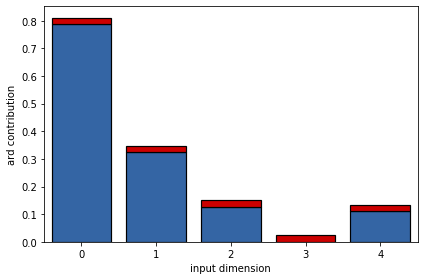

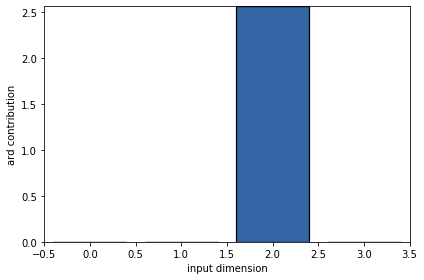

In [10]:
# Plot ARD scales per layer
m.obslayer.kern.plot_ARD()
m.layer_1.kern.plot_ARD()

Text(0.5, 1.0, 'Layer 1')

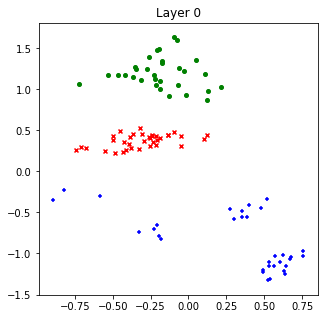

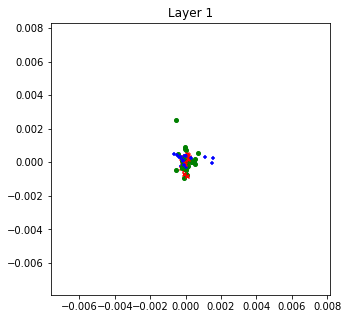

In [11]:
# From the plots above, we see which ones are the dominant dimensions for each layer. 
# So we use these dimensions in the visualization of the latent space below.
plt.figure(figsize=(5,5))
deepgp.util.visualize_DGP(m, labels, layer=0, dims=[1,2]); plt.title('Layer 0')
plt.figure(figsize=(5,5))
deepgp.util.visualize_DGP(m, labels, layer=1, dims=[0,1]); plt.title('Layer 1')

## Supervised learning

In [13]:
# Load some mocap data.
data = pods.datasets.cmu_mocap_35_walk_jog()

Ntr = 100
Nts = 500

# All data represented in Y_all, which is the angles of the movement of the subject
Y_all = data['Y']
perm = np.random.permutation(Ntr+Nts)
index_training = np.sort(perm[0:Ntr])
index_test     = np.sort(perm[Ntr:Ntr+Nts])

Y_all_tr = Y_all[index_training,:]
Y_all_ts = Y_all[index_test,    :]


# Some of the features (body joints) to be used as inputs, and some as outputs
X_tr = Y_all_tr[:,0:55].copy()
Y_tr = Y_all_tr[:, 55:].copy()

X_ts = Y_all_ts[:,0:55].copy()
Y_ts = Y_all_ts[:, 55:].copy()

# TODO: You might need to normalize the input and/or output data.

In [14]:
print(X_tr.shape)
print(Y_tr.shape)

(100, 55)
(100, 7)


In [26]:
# Number of latent dimensions (single hidden layer, since the top layer is observed)
Q = 5

# Define what kernels to use per layer
kern1 = GPy.kern.RBF(Q,ARD=True) + GPy.kern.Bias(Q)
kern2 = GPy.kern.RBF(X_tr.shape[1],ARD=False) + GPy.kern.Bias(X_tr.shape[1])

# Number of inducing points to use
num_inducing = 10

# Whether to use back-constraint for variational posterior
back_constraint = False

# Dimensions of the MLP back-constraint if set to true
encoder_dims=[[300],[150]]

In [27]:
m = deepgp.DeepGP([Y_tr.shape[1],Q,X_tr.shape[1]],
                  Y_tr, X_tr=X_tr,kernels=[kern1, kern2], 
                  num_inducing=num_inducing, back_constraint=back_constraint)

In [28]:
# Make sure initial noise variance gives a reasonable signal to noise ratio.
# Fix to that value for a few iterations to avoid early local minima
for i in range(len(m.layers)):
    output_var = m.layers[i].Y.var() if i==0 else m.layers[i].Y.mean.var()
    m.layers[i].Gaussian_noise.variance = output_var*0.01
    m.layers[i].Gaussian_noise.variance.fix()

In [29]:
display(m)

deepgp.,value,constraints,priors
obslayer.inducing inputs,"(10, 5)",,
obslayer.sum.rbf.variance,1.0,+ve,
obslayer.sum.rbf.lengthscale,"(5,)",+ve,
obslayer.sum.bias.variance,1.0,+ve,
obslayer.Gaussian_noise.variance,2.1319089903128967,+ve fixed,
obslayer.Kuu_var,"(10,)",+ve,
obslayer.latent space.mean,"(100, 5)",,
obslayer.latent space.variance,"(100, 5)",+ve,
layer_1.inducing inputs,"(10, 55)",,
layer_1.sum.rbf.variance,1.0,+ve,


In [30]:
m.optimize(max_iters=800, messages=True)

In [31]:
# Unfix noise variance now that we have initialized the model
for i in range(len(m.layers)):
    m.layers[i].Gaussian_noise.variance.unfix()

In [32]:
m.optimize(max_iters=1500, messages=True)

### Compare with GP

In [33]:
m_GP = GPy.models.SparseGPRegression(X=X_tr, Y=Y_tr, kernel=GPy.kern.RBF(X_tr.shape[1])+GPy.kern.Bias(X_tr.shape[1]), num_inducing=num_inducing)

In [34]:
m_GP.Gaussian_noise.variance = m_GP.Y.var()*0.01
m_GP.Gaussian_noise.variance.fix()
m_GP.optimize(max_iters=100, messages=True)
m_GP.Gaussian_noise.variance.unfix()
m_GP.optimize(max_iters=400, messages=True)

In [35]:
def rmse(predictions, targets):
    return np.sqrt(((predictions.flatten() - targets.flatten()) ** 2).mean())


In [36]:
Y_pred = m.predict(X_ts)[0]
Y_pred_s = m.predict_withSamples(X_ts, nSamples=500)[0]
Y_pred_GP = m_GP.predict(X_ts)[0]

print('# RMSE DGP               : ' + str(rmse(Y_pred, Y_ts)))
print('# RMSE DGP (with samples): ' + str(rmse(Y_pred_s, Y_ts)))
print('# RMSE GP                : ' + str(rmse(Y_pred_GP, Y_ts)))

# RMSE DGP               : 3.0327156763523595
# RMSE DGP (with samples): 3.0333575317976513
# RMSE GP                : 3.0339631694830675


In [37]:
y

NameError: name 'y' is not defined

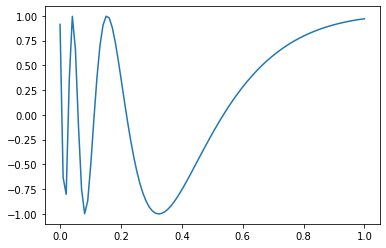

In [41]:
X = np.linspace(0,1,100)
Y = np.sin(2/(0.1+X))
plt.plot(X,Y)